LINE GRAPH - Total Number of Asthma Cases by Year by UHF34

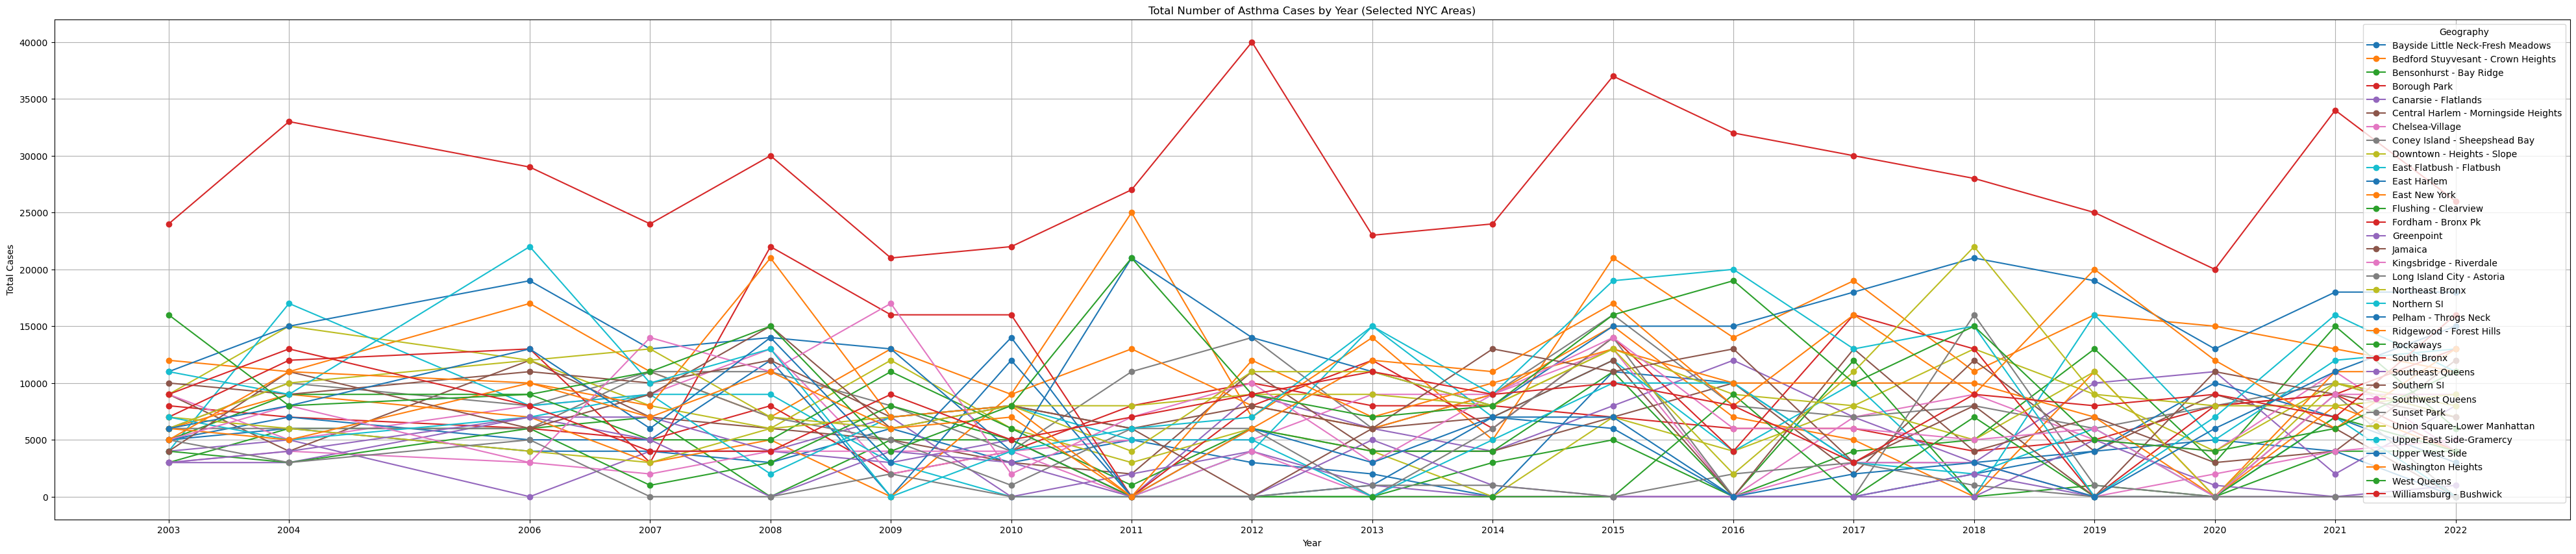

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import re

# 1. Read your CSV
df = pd.read_csv("NYC EH Data Portal - Adults with asthma (past 12 months) (full table).csv")


# 1. Converti TimePeriod in numero e arrotonda all'anno più vicino
df["TimePeriod"] = pd.to_numeric(df["TimePeriod"], errors="coerce").round(0).astype(int)

df = df[df["GeoType"] == "UHF34"]


# 3. Pulisci la colonna "Number" per estrarre il valore numerico
def extract_number(s):
    if pd.isna(s):
        return None
    s_clean = re.sub(r"[,\*]", "", s.strip())  # rimuove virgole e asterischi
    try:
        return float(s_clean)
    except ValueError:
        return None

df["TotalCases"] = df["Number"].apply(extract_number)

# 4. Fai il pivot in modo che ogni Geography sia una colonna distinta
df_pivot = df.pivot_table(
    index="TimePeriod",
    columns="Geography",
    values="TotalCases",
    aggfunc="sum"  # usa "sum" (o "mean") nel caso ci siano più righe per anno
)

# 5. Crea il grafico a linee
plt.figure(figsize=(50, 10))
for geo in df_pivot.columns:
    plt.plot(df_pivot.index, df_pivot[geo], marker="o", label=geo)

plt.title("Total Number of Asthma Cases by Year (Selected NYC Areas)")
plt.xlabel("Year")
plt.ylabel("Total Cases")
plt.legend(title="Geography")
plt.grid(True)

# Se vuoi forzare i ticks dell'asse X a essere solo interi
all_years = df_pivot.index.tolist()
plt.xticks(all_years, all_years)

plt.show()


MAP- Total Number of Asthma Cases by Year by borough

In [43]:
import pandas as pd
import geopandas as gpd
import re
import requests

from bokeh.io import output_file, show
from bokeh.models import GeoJSONDataSource, LinearColorMapper, ColorBar, HoverTool, Select, CustomJS
from bokeh.plotting import figure
from bokeh.layouts import column
from bokeh.palettes import OrRd6 as palette
palette = palette[::-1]

# 1. Carica i dati CSV
df = pd.read_csv("NYC EH Data Portal - Adults with asthma (past 12 months) (full table).csv")
df = df[df["GeoType"] == "Borough"]

valid_boroughs = ["New York City", "Brooklyn", "Bronx", "Queens", "Manhattan", "Staten Island"]
df = df[df["Geography"].isin(valid_boroughs)]

# Arrotonda anno
df["TimePeriod"] = pd.to_numeric(df["TimePeriod"], errors="coerce").round(0).astype("Int64")

# Pulisci il campo "Number"
def extract_number(s):
    if pd.isna(s):
        return None
    s_clean = re.sub(r"[,\*]", "", s.strip())
    try:
        return float(s_clean)
    except ValueError:
        return None

df["TotalCases"] = df["Number"].apply(extract_number)

# 2. Carica confini geografici dei borough da NYC OpenData
geojson_url = "https://raw.githubusercontent.com/dwillis/nyc-maps/master/boroughs.geojson"
boroughs = gpd.read_file(geojson_url)

# 3. Costruisci un dizionario: anno -> dati GeoJSON con "TotalCases" aggiornati
geojson_per_year = {}

for year in sorted(df["TimePeriod"].dropna().unique()):
    df_year = df[df["TimePeriod"] == year]
    merged = boroughs.copy()
    merged["TotalCases"] = merged["BoroName"].map(df_year.set_index("Geography")["TotalCases"].to_dict())
    geojson_per_year[str(year)] = merged.to_json()

# 4. Inizializza GeoJSONDataSource con l'anno di default
initial_year = sorted(geojson_per_year.keys())[0]
geo_source = GeoJSONDataSource(geojson=geojson_per_year[initial_year])

# 5. Mappa interattiva con Bokeh
color_mapper = LinearColorMapper(palette=palette,
                                  low=min(df["TotalCases"]),
                                  high=max(df["TotalCases"]))

p = figure(title=f"Asthma Cases by Borough - {initial_year}",
           toolbar_location="above",
           x_axis_location=None, y_axis_location=None,
           width=800, height=600)
p.grid.grid_line_color = None

patches = p.patches('xs', 'ys', source=geo_source,
                    fill_color={'field': 'TotalCases', 'transform': color_mapper},
                    line_color="white", line_width=0.5,
                    fill_alpha=0.7)

hover = HoverTool(tooltips=[("Borough", "@BoroName"),
                            ("Asthma Cases", "@TotalCases")])
p.add_tools(hover)

color_bar = ColorBar(color_mapper=color_mapper, location=(0, 0), title="Cases")
p.add_layout(color_bar, 'right')

# 6. Dropdown per selezione anno
select = Select(title="Select Year:", value=initial_year,
                options=sorted(geojson_per_year.keys()))

# 7. JavaScript callback per aggiornare la mappa
select.js_on_change("value", CustomJS(args=dict(source=geo_source,
                                                geojsons=geojson_per_year,
                                                fig=p),
                                      code="""
    const year = cb_obj.value;
    source.geojson = geojsons[year];
    fig.title.text = `Asthma Cases by Borough - ${year}`;
"""))

# 8. Layout e output
layout = column(select, p)
output_file("interactive_asthma_map.html")
show(layout)


MAP - Total Number of Asthma Cases by Year by UHF34

In [44]:
import pandas as pd
import geopandas as gpd
import re
import requests

from bokeh.io import output_file, show
from bokeh.models import GeoJSONDataSource, LinearColorMapper, ColorBar, HoverTool, Select, CustomJS
from bokeh.plotting import figure
from bokeh.layouts import column
from bokeh.palettes import OrRd6 as palette
palette = palette[::-1]

# 1. Carica i dati CSV
df = pd.read_csv("NYC EH Data Portal - Adults with asthma (past 12 months) (full table).csv")
df = df[df["GeoType"] == "UHF34"]

# Arrotonda anno
df["TimePeriod"] = pd.to_numeric(df["TimePeriod"], errors="coerce").round(0).astype("Int64")

# Pulisci il campo "Number"
def extract_number(s):
    if pd.isna(s):
        return None
    s_clean = re.sub(r"[,\*]", "", s.strip())
    try:
        return float(s_clean)
    except ValueError:
        return None

df["TotalCases"] = df["Number"].apply(extract_number)

# 2. Carica confini geografici dei borough da NYC OpenData
geojson_url = "https://raw.githubusercontent.com/nycehs/NYC_geography/master/UHF34.geo.json"
boroughs = gpd.read_file(geojson_url)

# 3. Costruisci un dizionario: anno -> dati GeoJSON con "TotalCases" aggiornati
geojson_per_year = {}

for year in sorted(df["TimePeriod"].dropna().unique()):
    df_year = df[df["TimePeriod"] == year]
    merged = boroughs.copy()
    merged["TotalCases"] = merged["GEONAME"].map(df_year.set_index("Geography")["TotalCases"].to_dict())
    geojson_per_year[str(year)] = merged.to_json()

# 4. Inizializza GeoJSONDataSource con l'anno di default
initial_year = sorted(geojson_per_year.keys())[0]
geo_source = GeoJSONDataSource(geojson=geojson_per_year[initial_year])

# 5. Mappa interattiva con Bokeh
color_mapper = LinearColorMapper(palette=palette,
                                  low=min(df["TotalCases"]),
                                  high=max(df["TotalCases"]))

p = figure(title=f"Asthma Cases by district - {initial_year}",
           toolbar_location="above",
           x_axis_location=None, y_axis_location=None,
           width=800, height=600)
p.grid.grid_line_color = None

patches = p.patches('xs', 'ys', source=geo_source,
                    fill_color={'field': 'TotalCases', 'transform': color_mapper},
                    line_color="white", line_width=0.5,
                    fill_alpha=0.7)

hover = HoverTool(tooltips=[("District", "@GEONAME"),
                            ("Asthma Cases", "@TotalCases")])
p.add_tools(hover)

color_bar = ColorBar(color_mapper=color_mapper, location=(0, 0), title="Cases")
p.add_layout(color_bar, 'right')

# 6. Dropdown per selezione anno
select = Select(title="Select Year:", value=initial_year,
                options=sorted(geojson_per_year.keys()))

# 7. JavaScript callback per aggiornare la mappa
select.js_on_change("value", CustomJS(args=dict(source=geo_source,
                                                geojsons=geojson_per_year,
                                                fig=p),
                                      code="""
    const year = cb_obj.value;
    source.geojson = geojsons[year];
    fig.title.text = `Asthma Cases by Borough - ${year}`;
"""))

# 8. Layout e output
layout = column(select, p)
output_file("asthma_map_UHF34.html")
show(layout)


LINEGRAPH - PM2.5 level by year by UHF34

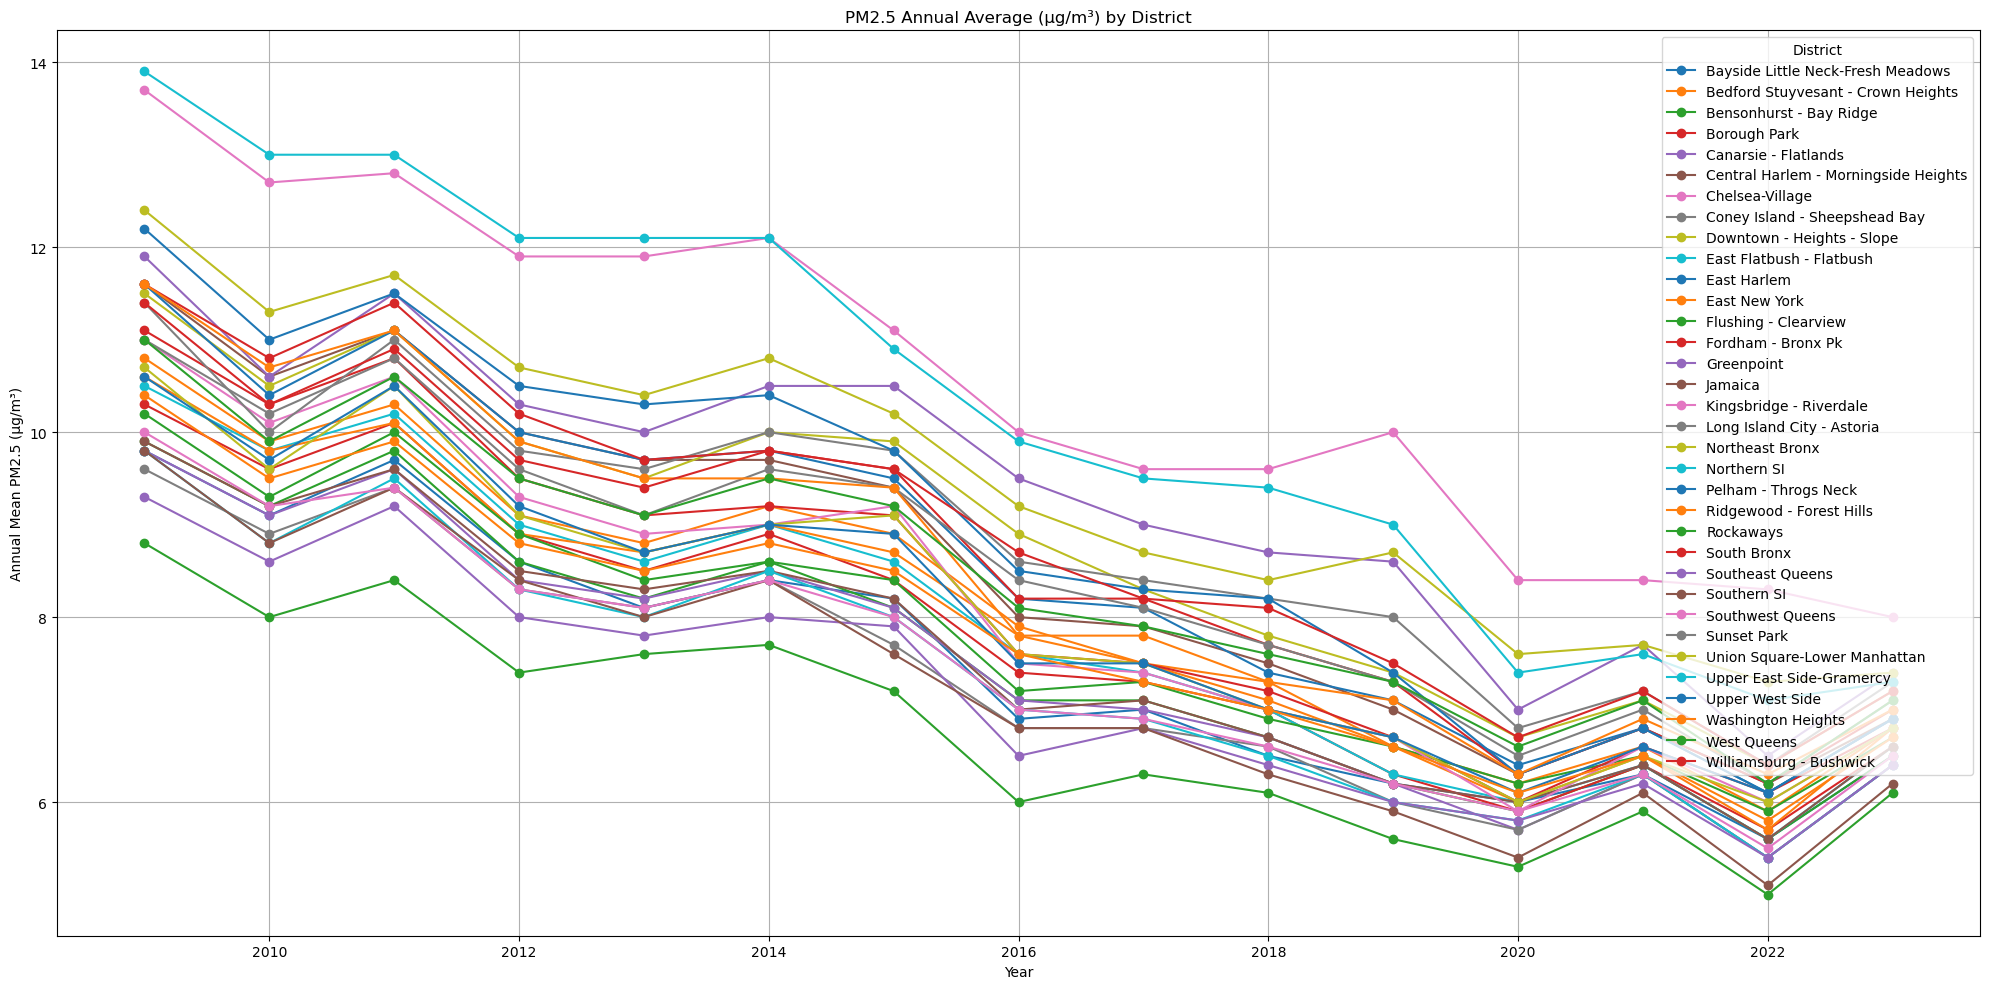

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Carica il dataset
df = pd.read_csv("NYC EH Data Portal - Fine particles (PM 2.5) (full table).csv")

# 2. Filtra per GeoType == 'Borough'
df = df[df["GeoType"] == "UHF34"]

# 3. Seleziona solo le colonne utili
df = df[["TimePeriod", "Geography", "Annual mean mcg/m3"]]

# 4. Pulisci i dati
df["TimePeriod"] = pd.to_numeric(df["TimePeriod"], errors="coerce").astype("Int64")
df["Annual mean mcg/m3"] = pd.to_numeric(df["Annual mean mcg/m3"], errors="coerce")

# 5. Pivot per line chart
df_pivot = df.pivot(index="TimePeriod", columns="Geography", values="Annual mean mcg/m3")

# 6. Crea il grafico
plt.figure(figsize=(20, 10))
for borough in df_pivot.columns:
    plt.plot(df_pivot.index, df_pivot[borough], marker="o", label=borough)

plt.title("PM2.5 Annual Average (µg/m³) by District")
plt.xlabel("Year")
plt.ylabel("Annual Mean PM2.5 (µg/m³)")
plt.grid(True)
plt.legend(title="District")
plt.tight_layout()
plt.show()


MAP - 2.5PM level by year by district by UHF34

In [ ]:
import pandas as pd
import geopandas as gpd
from bokeh.io import output_file, save
from bokeh.models import GeoJSONDataSource, LinearColorMapper, ColorBar, HoverTool, CustomJS, Select
from bokeh.palettes import OrRd6 as palette
from bokeh.plotting import figure
from bokeh.layouts import column
import json
import requests

# 1. Carica dataset PM2.5
df = pd.read_csv("NYC EH Data Portal - Fine particles (PM 2.5) (full table).csv")
df = df[df["GeoType"] == "UHF34"]
df = df[["TimePeriod", "Geography", "Annual mean mcg/m3"]]
df = df.rename(columns={"Geography": "UHF34", "Annual mean mcg/m3": "PM25"})
df["TimePeriod"] = pd.to_numeric(df["TimePeriod"], errors="coerce").astype("Int64")
df["PM25"] = pd.to_numeric(df["PM25"], errors="coerce")

# 2. Carica GeoJSON delle UHF34
geojson_url = "https://raw.githubusercontent.com/nycehs/NYC_geography/master/UHF34.geo.json"
boroughs = gpd.read_file(geojson_url)
boroughs = boroughs.rename(columns={"GEONAME": "UHF34"})

# 3. Crea GeoJSON per ogni anno disponibile
geojson_by_year = {}
years = sorted(df["TimePeriod"].dropna().unique())

for year in years:
    year_df = df[df["TimePeriod"] == year]
    merged = boroughs.copy()
    # Mappa PM25 sui distretti UHF34
    merged["PM25"] = merged["UHF34"].map(year_df.set_index("UHF34")["PM25"].to_dict())
    geojson_by_year[str(year)] = json.loads(merged.to_json())

# 4. Fonte iniziale
initial_year = str(years[0])
geo_source = GeoJSONDataSource(geojson=json.dumps(geojson_by_year[initial_year]))

# 5. Colormap
palette = palette[::-1]
color_mapper = LinearColorMapper(palette=palette,
                                 low=df["PM25"].min(),
                                 high=df["PM25"].max())

# 6. Figura
p = figure(title=f"PM2.5 Annual Average - {initial_year}",
           toolbar_location="above",
           x_axis_location=None, y_axis_location=None,
           width=800, height=600)
p.grid.grid_line_color = None

patches = p.patches('xs', 'ys', source=geo_source,
                    fill_color={'field': 'PM25', 'transform': color_mapper},
                    line_color="white", line_width=0.5,
                    fill_alpha=0.8)

# 7. Tooltip
hover = HoverTool(tooltips=[
    ("UHF34 District", "@UHF34"),
    ("PM2.5 (µg/m³)", "@PM25")
])
p.add_tools(hover)

# 8. Color bar
color_bar = ColorBar(color_mapper=color_mapper, location=(0, 0), title="PM2.5 µg/m³")
p.add_layout(color_bar, 'right')

# 9. Dropdown
select = Select(title="Select Year", value=initial_year, options=[str(y) for y in years])

# 10. JavaScript: dati preiniettati nel browser
select.js_on_change("value", CustomJS(args=dict(source=geo_source,
                                                geojsons=geojson_by_year,
                                                plot=p),
                                      code="""
    const year = cb_obj.value;
    source.geojson = JSON.stringify(geojsons[year]);
    plot.title.text = `PM2.5 Annual Average - ${year}`;
"""))

# 11. Output HTML
layout = column(select, p)
output_file("pm25_map_interactive.html")
save(layout)


'c:\\Users\\camil\\Desktop\\UNI\\MAGISTRALE\\Social Data Analysis\\Final Project\\code and data\\pm25_map_interactive.html'

MAP - 2.5PM level by year by district by borough

In [ ]:
import pandas as pd
import geopandas as gpd
from bokeh.io import output_file, save
from bokeh.models import GeoJSONDataSource, LinearColorMapper, ColorBar, HoverTool, CustomJS, Select
from bokeh.palettes import OrRd6 as palette
from bokeh.plotting import figure
from bokeh.layouts import column
import json
import requests

# 1. Carica dataset PM2.5
df = pd.read_csv("NYC EH Data Portal - Fine particles (PM 2.5) (full table).csv")
df = df[df["GeoType"] == "Borough"]
df = df[["TimePeriod", "Geography", "Annual mean mcg/m3"]]
df = df.rename(columns={"Geography": "Borough", "Annual mean mcg/m3": "PM25"})
df["TimePeriod"] = pd.to_numeric(df["TimePeriod"], errors="coerce").astype("Int64")
df["PM25"] = pd.to_numeric(df["PM25"], errors="coerce")

# 2. Carica GeoJSON dei borough
geojson_url = "https://raw.githubusercontent.com/dwillis/nyc-maps/master/boroughs.geojson"
boroughs = gpd.read_file(geojson_url)

# 3. Crea GeoJSON per ogni anno disponibile
geojson_by_year = {}
years = sorted(df["TimePeriod"].dropna().unique())

for year in years:
    year_df = df[df["TimePeriod"] == year]
    merged = boroughs.copy()
    merged["PM25"] = merged["BoroName"].map(year_df.set_index("Borough")["PM25"].to_dict())
    geojson_by_year[str(year)] = json.loads(merged.to_json())

# 4. Fonte iniziale
initial_year = str(years[0])
geo_source = GeoJSONDataSource(geojson=json.dumps(geojson_by_year[initial_year]))

# 5. Colormap
palette = palette[::-1]
color_mapper = LinearColorMapper(palette=palette,
                                 low=df["PM25"].min(),
                                 high=df["PM25"].max())

# 6. Figura
p = figure(title=f"PM2.5 Annual Average - {initial_year}",
           toolbar_location="above",
           x_axis_location=None, y_axis_location=None,
           width=800, height=600)
p.grid.grid_line_color = None

patches = p.patches('xs', 'ys', source=geo_source,
                    fill_color={'field': 'PM25', 'transform': color_mapper},
                    line_color="white", line_width=0.5,
                    fill_alpha=0.8)

# 7. Tooltip
hover = HoverTool(tooltips=[
    ("Borough", "@BoroName"),
    ("PM2.5 (µg/m³)", "@PM25")
])
p.add_tools(hover)

# 8. Color bar
color_bar = ColorBar(color_mapper=color_mapper, location=(0, 0), title="PM2.5 µg/m³")
p.add_layout(color_bar, 'right')

# 9. Dropdown
select = Select(title="Select Year", value=initial_year, options=[str(y) for y in years])

# 10. JavaScript: dati preiniettati nel browser
select.js_on_change("value", CustomJS(args=dict(source=geo_source,
                                                geojsons=geojson_by_year,
                                                plot=p),
                                      code="""
    const year = cb_obj.value;
    source.geojson = JSON.stringify(geojsons[year]);
    plot.title.text = `PM2.5 Annual Average - ${year}`;
"""))

# 11. Output HTML
layout = column(select, p)
output_file("pm25_map_interactive.html")
save(layout)


combined viz

In [ ]:
import pandas as pd

# 1. Carica dati asma
df_asma = pd.read_csv("NYC EH Data Portal - Adults with asthma (past 12 months) (full table).csv")
df_asma = df_asma[df_asma["GeoType"] == "Borough"]
df_asma["TimePeriod"] = pd.to_numeric(df_asma["TimePeriod"], errors="coerce").astype("Int64")
df_asma["Percent"] = df_asma["Percent"].str.extract(r"([\d\.]+)").astype(float)
df_asma = df_asma[["TimePeriod", "Geography", "Percent"]]
df_asma = df_asma.rename(columns={"Geography": "Borough", "Percent": "AsthmaPercent"})

# 2. Carica dati PM2.5
df_pm = pd.read_csv("NYC EH Data Portal - Fine particles (PM 2.5) (full table).csv")
df_pm = df_pm[df_pm["GeoType"] == "Borough"]
df_pm["TimePeriod"] = pd.to_numeric(df_pm["TimePeriod"], errors="coerce").astype("Int64")
df_pm["Annual mean mcg/m3"] = pd.to_numeric(df_pm["Annual mean mcg/m3"], errors="coerce")
df_pm = df_pm.rename(columns={"Geography": "Borough", "Annual mean mcg/m3": "PM25"})
df_pm = df_pm[["TimePeriod", "Borough", "PM25"]]

# 3. Merge
df_merged = pd.merge(df_asma, df_pm, on=["TimePeriod", "Borough"])


LINE GRAPH - combined asthma and pm2.5 levels by borough

C:\Users\camil\AppData\Local\Temp\ipykernel_32440\364986586.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("tab10", len(boroughs))


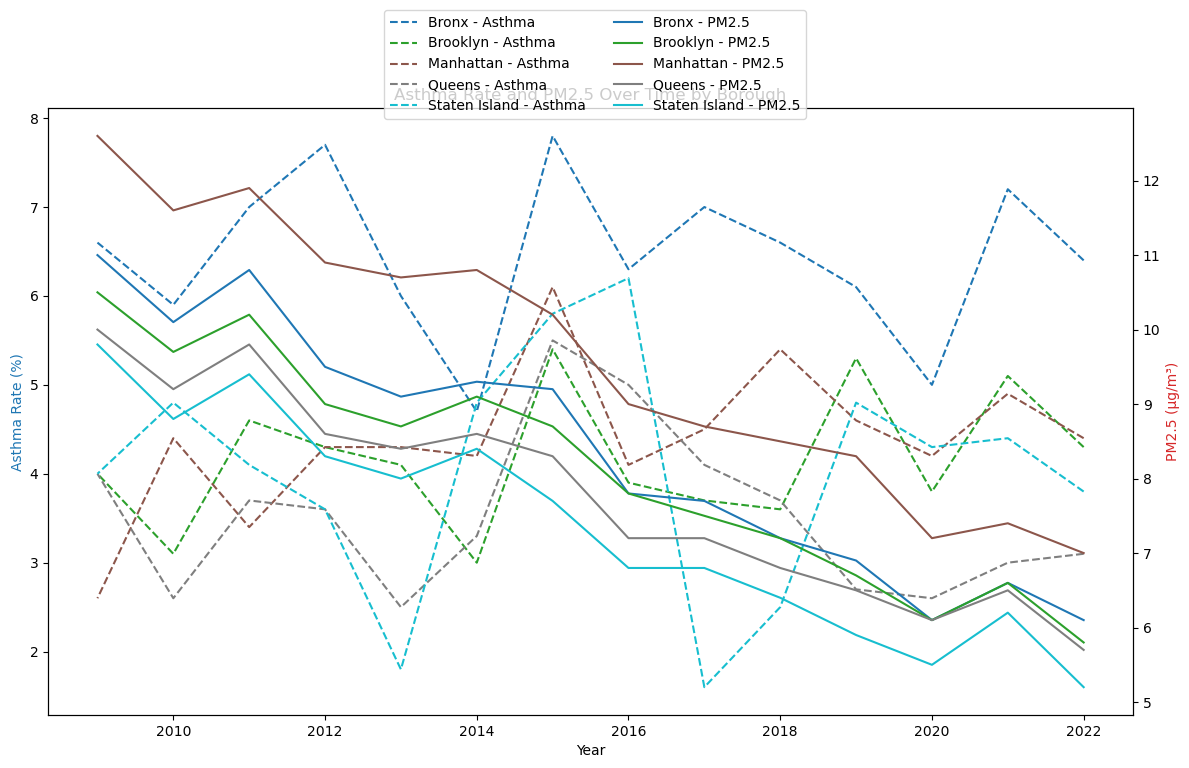

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assumendo che tu abbia già df_merged con: TimePeriod, Borough, AsthmaPercent, PM25
boroughs = df_merged["Borough"].unique()
colors = plt.cm.get_cmap("tab10", len(boroughs))

fig, ax1 = plt.subplots(figsize=(12, 7))

# Colori coerenti per borough
for i, borough in enumerate(boroughs):
    bdata = df_merged[df_merged["Borough"] == borough]
    ax1.plot(bdata["TimePeriod"], bdata["AsthmaPercent"],
             linestyle="--", color=colors(i), label=f"{borough} - Asthma")

# Secondo asse per PM2.5
ax2 = ax1.twinx()
for i, borough in enumerate(boroughs):
    bdata = df_merged[df_merged["Borough"] == borough]
    ax2.plot(bdata["TimePeriod"], bdata["PM25"],
             linestyle="-", color=colors(i), label=f"{borough} - PM2.5")

# Etichette assi
ax1.set_xlabel("Year")
ax1.set_ylabel("Asthma Rate (%)", color="tab:blue")
ax2.set_ylabel("PM2.5 (µg/m³)", color="tab:red")
plt.title("Asthma Rate and PM2.5 Over Time by Borough")

# Legenda combinata
# Legenda combinata (corretto)
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()

lines = lines1 + lines2
labels = labels1 + labels2

fig.legend(lines, labels, loc="upper center", bbox_to_anchor=(0.5, 1.1), ncol=2)


plt.tight_layout()
plt.show()


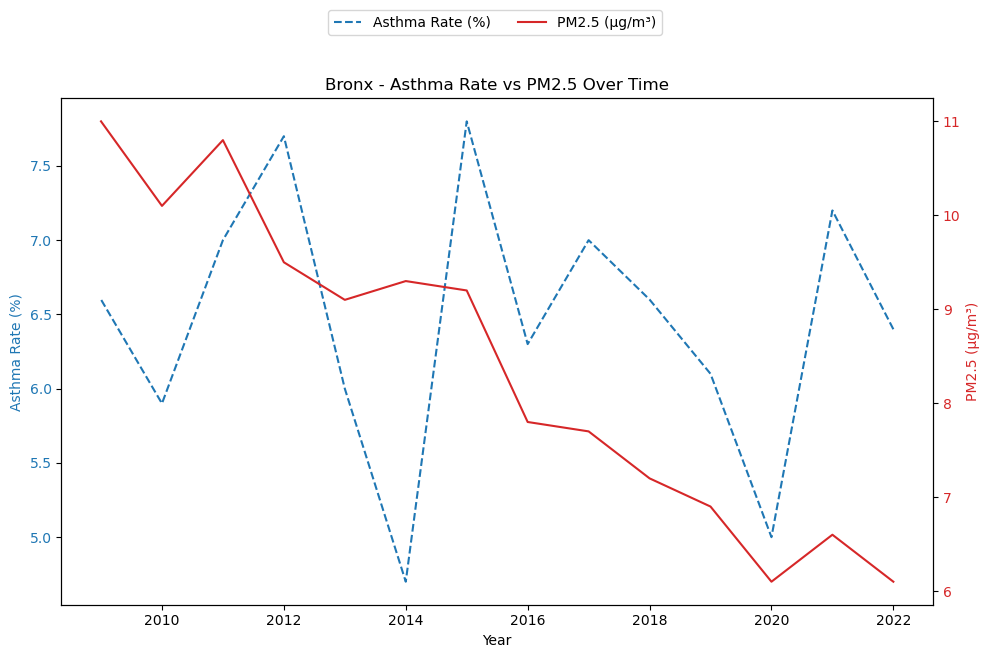

In [ ]:
# Filtra per il borough
borough = "Bronx"
data = df_merged[df_merged["Borough"] == borough]

# Plot
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.plot(data["TimePeriod"], data["AsthmaPercent"], color="tab:blue", linestyle="--", label="Asthma Rate (%)")
ax1.set_xlabel("Year")
ax1.set_ylabel("Asthma Rate (%)", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")

ax2 = ax1.twinx()
ax2.plot(data["TimePeriod"], data["PM25"], color="tab:red", label="PM2.5 (µg/m³)")
ax2.set_ylabel("PM2.5 (µg/m³)", color="tab:red")
ax2.tick_params(axis="y", labelcolor="tab:red")

plt.title(f"Bronx - Asthma Rate vs PM2.5 Over Time")

# Legenda
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines = lines1 + lines2
labels = labels1 + labels2
fig.legend(lines, labels, loc="upper center", bbox_to_anchor=(0.5, 1.1), ncol=2)

plt.tight_layout()
plt.show()


In [47]:
# Filtra per il borough
borough = "Brooklyn"
data = df_merged[df_merged["Borough"] == borough]

# Plot
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.plot(data["TimePeriod"], data["AsthmaPercent"], color="tab:blue", linestyle="--", label="Asthma Rate (%)")
ax1.set_xlabel("Year")
ax1.set_ylabel("Asthma Rate (%)", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")

ax2 = ax1.twinx()
ax2.plot(data["TimePeriod"], data["PM25"], color="tab:red", label="PM2.5 (µg/m³)")
ax2.set_ylabel("PM2.5 (µg/m³)", color="tab:red")
ax2.tick_params(axis="y", labelcolor="tab:red")

plt.title(f"Brooklyn - asthma Rate vs PM2.5 Over Time")

# Legenda
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines = lines1 + lines2
labels = labels1 + labels2
fig.legend(lines, labels, loc="upper center", bbox_to_anchor=(0.5, 1.1), ncol=2)

plt.tight_layout()
plt.show()


KeyError: 'Borough'

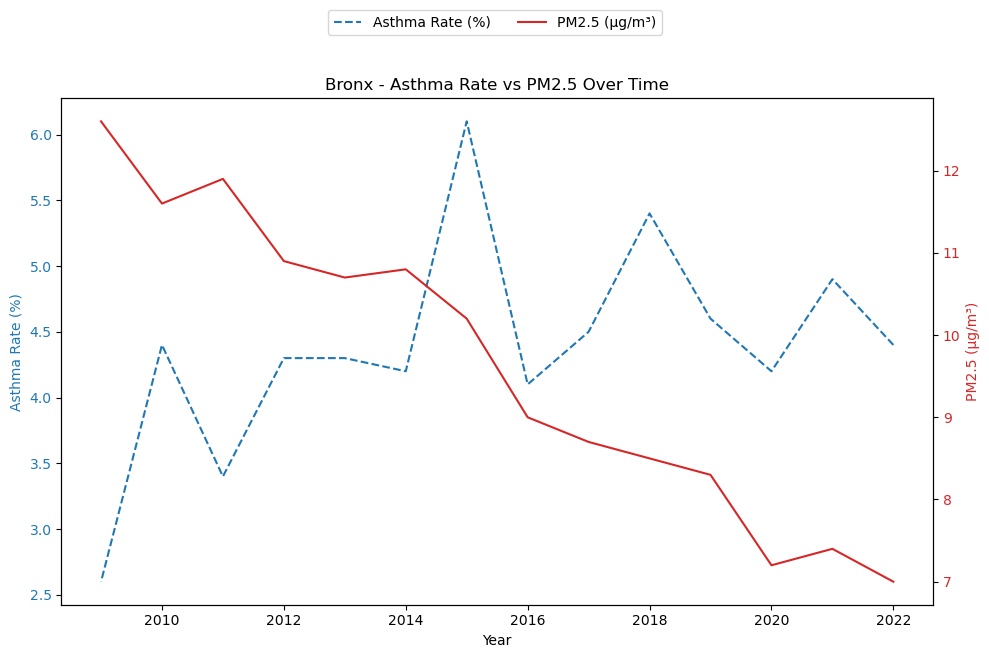

In [ ]:
# Filtra per il borough
borough = "Manhattan"
data = df_merged[df_merged["Borough"] == borough]

# Plot
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.plot(data["TimePeriod"], data["AsthmaPercent"], color="tab:blue", linestyle="--", label="Asthma Rate (%)")
ax1.set_xlabel("Year")
ax1.set_ylabel("Asthma Rate (%)", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")

ax2 = ax1.twinx()
ax2.plot(data["TimePeriod"], data["PM25"], color="tab:red", label="PM2.5 (µg/m³)")
ax2.set_ylabel("PM2.5 (µg/m³)", color="tab:red")
ax2.tick_params(axis="y", labelcolor="tab:red")

plt.title(f"Bronx - Asthma Rate vs PM2.5 Over Time")

# Legenda
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines = lines1 + lines2
labels = labels1 + labels2
fig.legend(lines, labels, loc="upper center", bbox_to_anchor=(0.5, 1.1), ncol=2)

plt.tight_layout()
plt.show()


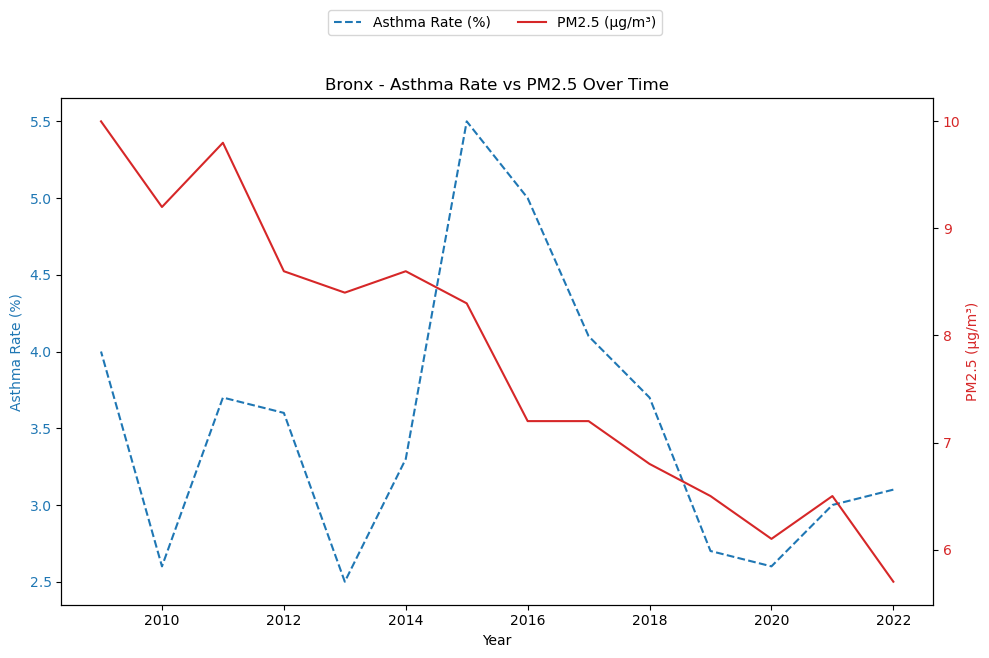

In [ ]:
# Filtra per il borough
borough = "Queens"
data = df_merged[df_merged["Borough"] == borough]

# Plot
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.plot(data["TimePeriod"], data["AsthmaPercent"], color="tab:blue", linestyle="--", label="Asthma Rate (%)")
ax1.set_xlabel("Year")
ax1.set_ylabel("Asthma Rate (%)", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")

ax2 = ax1.twinx()
ax2.plot(data["TimePeriod"], data["PM25"], color="tab:red", label="PM2.5 (µg/m³)")
ax2.set_ylabel("PM2.5 (µg/m³)", color="tab:red")
ax2.tick_params(axis="y", labelcolor="tab:red")

plt.title(f"Bronx - Asthma Rate vs PM2.5 Over Time")

# Legenda
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines = lines1 + lines2
labels = labels1 + labels2
fig.legend(lines, labels, loc="upper center", bbox_to_anchor=(0.5, 1.1), ncol=2)

plt.tight_layout()
plt.show()


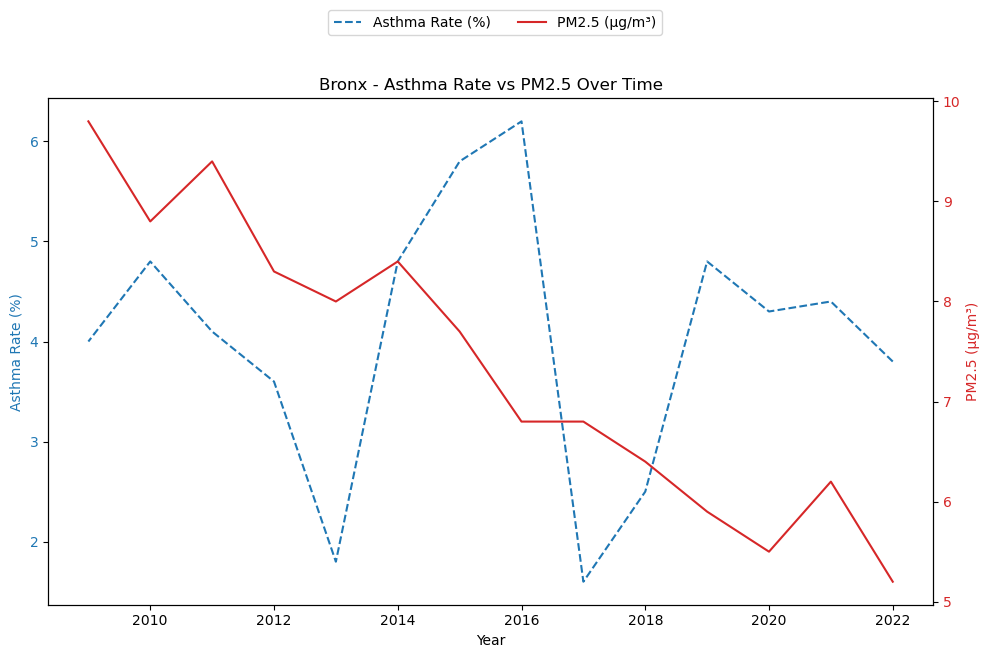

In [ ]:
# Filtra per il borough
borough = "Staten Island"
data = df_merged[df_merged["Borough"] == borough]

# Plot
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.plot(data["TimePeriod"], data["AsthmaPercent"], color="tab:blue", linestyle="--", label="Asthma Rate (%)")
ax1.set_xlabel("Year")
ax1.set_ylabel("Asthma Rate (%)", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")

ax2 = ax1.twinx()
ax2.plot(data["TimePeriod"], data["PM25"], color="tab:red", label="PM2.5 (µg/m³)")
ax2.set_ylabel("PM2.5 (µg/m³)", color="tab:red")
ax2.tick_params(axis="y", labelcolor="tab:red")

plt.title(f"Bronx - Asthma Rate vs PM2.5 Over Time")

# Legenda
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines = lines1 + lines2
labels = labels1 + labels2
fig.legend(lines, labels, loc="upper center", bbox_to_anchor=(0.5, 1.1), ncol=2)

plt.tight_layout()
plt.show()


Asthma, pollution comparison by bourough

In [ ]:
import pandas as pd
import geopandas as gpd
from bokeh.io import show
from bokeh.models import (
    GeoJSONDataSource, LinearColorMapper, ColorBar, Select, CustomJS,
    RadioButtonGroup, HoverTool
)
from bokeh.plotting import figure
from bokeh.layouts import column, row
from bokeh.palettes import Viridis256

# === 1. Carica i tuoi dati uniti ===
# Assumiamo che tu abbia già il DataFrame df_merged con:
# TimePeriod, Borough, AsthmaPercent, PM25

# === 2. Carica la mappa dei borough ===
geojson_url = "https://raw.githubusercontent.com/dwillis/nyc-maps/master/boroughs.geojson"
boroughs = gpd.read_file(geojson_url).rename(columns={"BoroName": "Borough"})

# === 3. Prepara GeoJSON per ogni anno ===
anni = sorted(df_merged["TimePeriod"].dropna().unique())
asma_jsons = {}
pm_jsons = {}

for year in anni:
    df_year = df_merged[df_merged["TimePeriod"] == year]
    merged = boroughs.merge(df_year, on="Borough", how="left")
    asma_jsons[str(year)] = merged[["geometry", "Borough", "AsthmaPercent"]].to_json()
    pm_jsons[str(year)] = merged[["geometry", "Borough", "PM25"]].to_json()

# === 4. Sorgenti iniziali ===
initial_year = str(anni[0])
asma_source = GeoJSONDataSource(geojson=asma_jsons[initial_year])
pm_source = GeoJSONDataSource(geojson=pm_jsons[initial_year])

# === 5. Color mapper ===
asma_mapper = LinearColorMapper(palette=Viridis256,
                                low=df_merged["AsthmaPercent"].min(),
                                high=df_merged["AsthmaPercent"].max())

pm_mapper = LinearColorMapper(palette=Viridis256,
                              low=df_merged["PM25"].min(),
                              high=df_merged["PM25"].max())

# === 6. Figura Bokeh ===
p = figure(title=f"Asthma Rate per Borough - {initial_year}",
           tools="pan,wheel_zoom,reset",
           x_axis_location=None, y_axis_location=None)
p.grid.grid_line_color = None

# === 7. Patches separati ===
asma_patch = p.patches("xs", "ys", source=asma_source,
                       fill_color={"field": "AsthmaPercent", "transform": asma_mapper},
                       line_color="white", line_width=0.5, fill_alpha=0.7,
                       visible=True)

pm_patch = p.patches("xs", "ys", source=pm_source,
                     fill_color={"field": "PM25", "transform": pm_mapper},
                     line_color="white", line_width=0.5, fill_alpha=0.7,
                     visible=False)

# === 8. Hover tool dinamico ===
hover_tool = HoverTool(
    tooltips=[("Borough", "@Borough"), ("Asthma %", "@AsthmaPercent")],
    renderers=[asma_patch]
)
p.add_tools(hover_tool)

# === 9. Color bar iniziale ===
color_bar = ColorBar(color_mapper=asma_mapper, label_standoff=12, location=(0, 0))
p.add_layout(color_bar, "right")

# === 10. Controlli interattivi ===
dropdown = Select(title="Select Year", value=initial_year, options=[str(y) for y in anni])
metric_switch = RadioButtonGroup(labels=["Asthma (%)", "PM2.5 (µg/m³)"], active=0)

# === 11. Callback JS ===
callback = CustomJS(args=dict(
    dropdown=dropdown,
    metric_switch=metric_switch,
    asma_source=asma_source,
    pm_source=pm_source,
    asma_jsons=asma_jsons,
    pm_jsons=pm_jsons,
    asma_patch=asma_patch,
    pm_patch=pm_patch,
    color_bar=color_bar,
    asma_mapper=asma_mapper,
    pm_mapper=pm_mapper,
    plot=p,
    hover_tool=hover_tool
), code="""
    const year = dropdown.value;
    const metric = metric_switch.active === 0 ? "asma" : "pm";

    if (metric === "asma") {
        asma_source.geojson = asma_jsons[year];
        asma_patch.visible = true;
        pm_patch.visible = false;
        hover_tool.tooltips = [["Borough", "@Borough"], ["Asthma %", "@AsthmaPercent"]];
        hover_tool.renderers = [asma_patch];
        color_bar.color_mapper = asma_mapper;
        plot.title.text = `Asthma Rate per Borough - ${year}`;
    } else {
        pm_source.geojson = pm_jsons[year];
        asma_patch.visible = false;
        pm_patch.visible = true;
        hover_tool.tooltips = [["Borough", "@Borough"], ["PM2.5 (µg/m³)", "@PM25"]];
        hover_tool.renderers = [pm_patch];
        color_bar.color_mapper = pm_mapper;
        plot.title.text = `PM2.5 Levels per Borough - ${year}`;
    }
""")

dropdown.js_on_change("value", callback)
metric_switch.js_on_change("active", callback)

# === 12. Layout finale ===
layout = column(row(dropdown, metric_switch), p)
show(layout)


Asthma, pollution comparison by United Hospital Fund 34. Which is the only common geotype between the two datasets. We see only areas for which we have data related to both air quality and ashtma

In [ ]:
import pandas as pd
import geopandas as gpd
import requests
import os
from bokeh.io import output_file, save
from bokeh.models import (
    GeoJSONDataSource, LinearColorMapper, ColorBar, Select, CustomJS,
    RadioButtonGroup, HoverTool
)
from bokeh.plotting import figure
from bokeh.layouts import column, row
from bokeh.palettes import Viridis256

# === 1. Load and prepare data ===
# Load asthma data
df_asma = pd.read_csv("NYC EH Data Portal - Adults with asthma (past 12 months) (full table).csv")
df_asma = df_asma[df_asma["GeoType"] == "UHF34"]
df_asma["TimePeriod"] = pd.to_numeric(df_asma["TimePeriod"], errors="coerce").astype("Int64")
df_asma["Percent"] = df_asma["Percent"].str.extract(r"([\d\.]+)").astype(float)
df_asma = df_asma[["TimePeriod", "Geography", "Percent"]]
df_asma = df_asma.rename(columns={"Geography": "UHF34", "Percent": "AsthmaPercent"})

# Load PM2.5 data
df_pm = pd.read_csv("NYC EH Data Portal - Fine particles (PM 2.5) (full table).csv")
df_pm = df_pm[df_pm["GeoType"] == "UHF34"]
df_pm["TimePeriod"] = pd.to_numeric(df_pm["TimePeriod"], errors="coerce").astype("Int64")
df_pm["Annual mean mcg/m3"] = pd.to_numeric(df_pm["Annual mean mcg/m3"], errors="coerce")
df_pm = df_pm.rename(columns={"Geography": "UHF34", "Annual mean mcg/m3": "PM25"})
df_pm = df_pm[["TimePeriod", "UHF34", "PM25"]]

# Merge asthma and PM2.5
df_merged = pd.merge(df_asma, df_pm, on=["TimePeriod", "UHF34"])

LINE CHART - asthma and pollutions level compared by UHF34

C:\Users\camil\AppData\Local\Temp\ipykernel_32440\1725068581.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("tab10", len(boroughs))


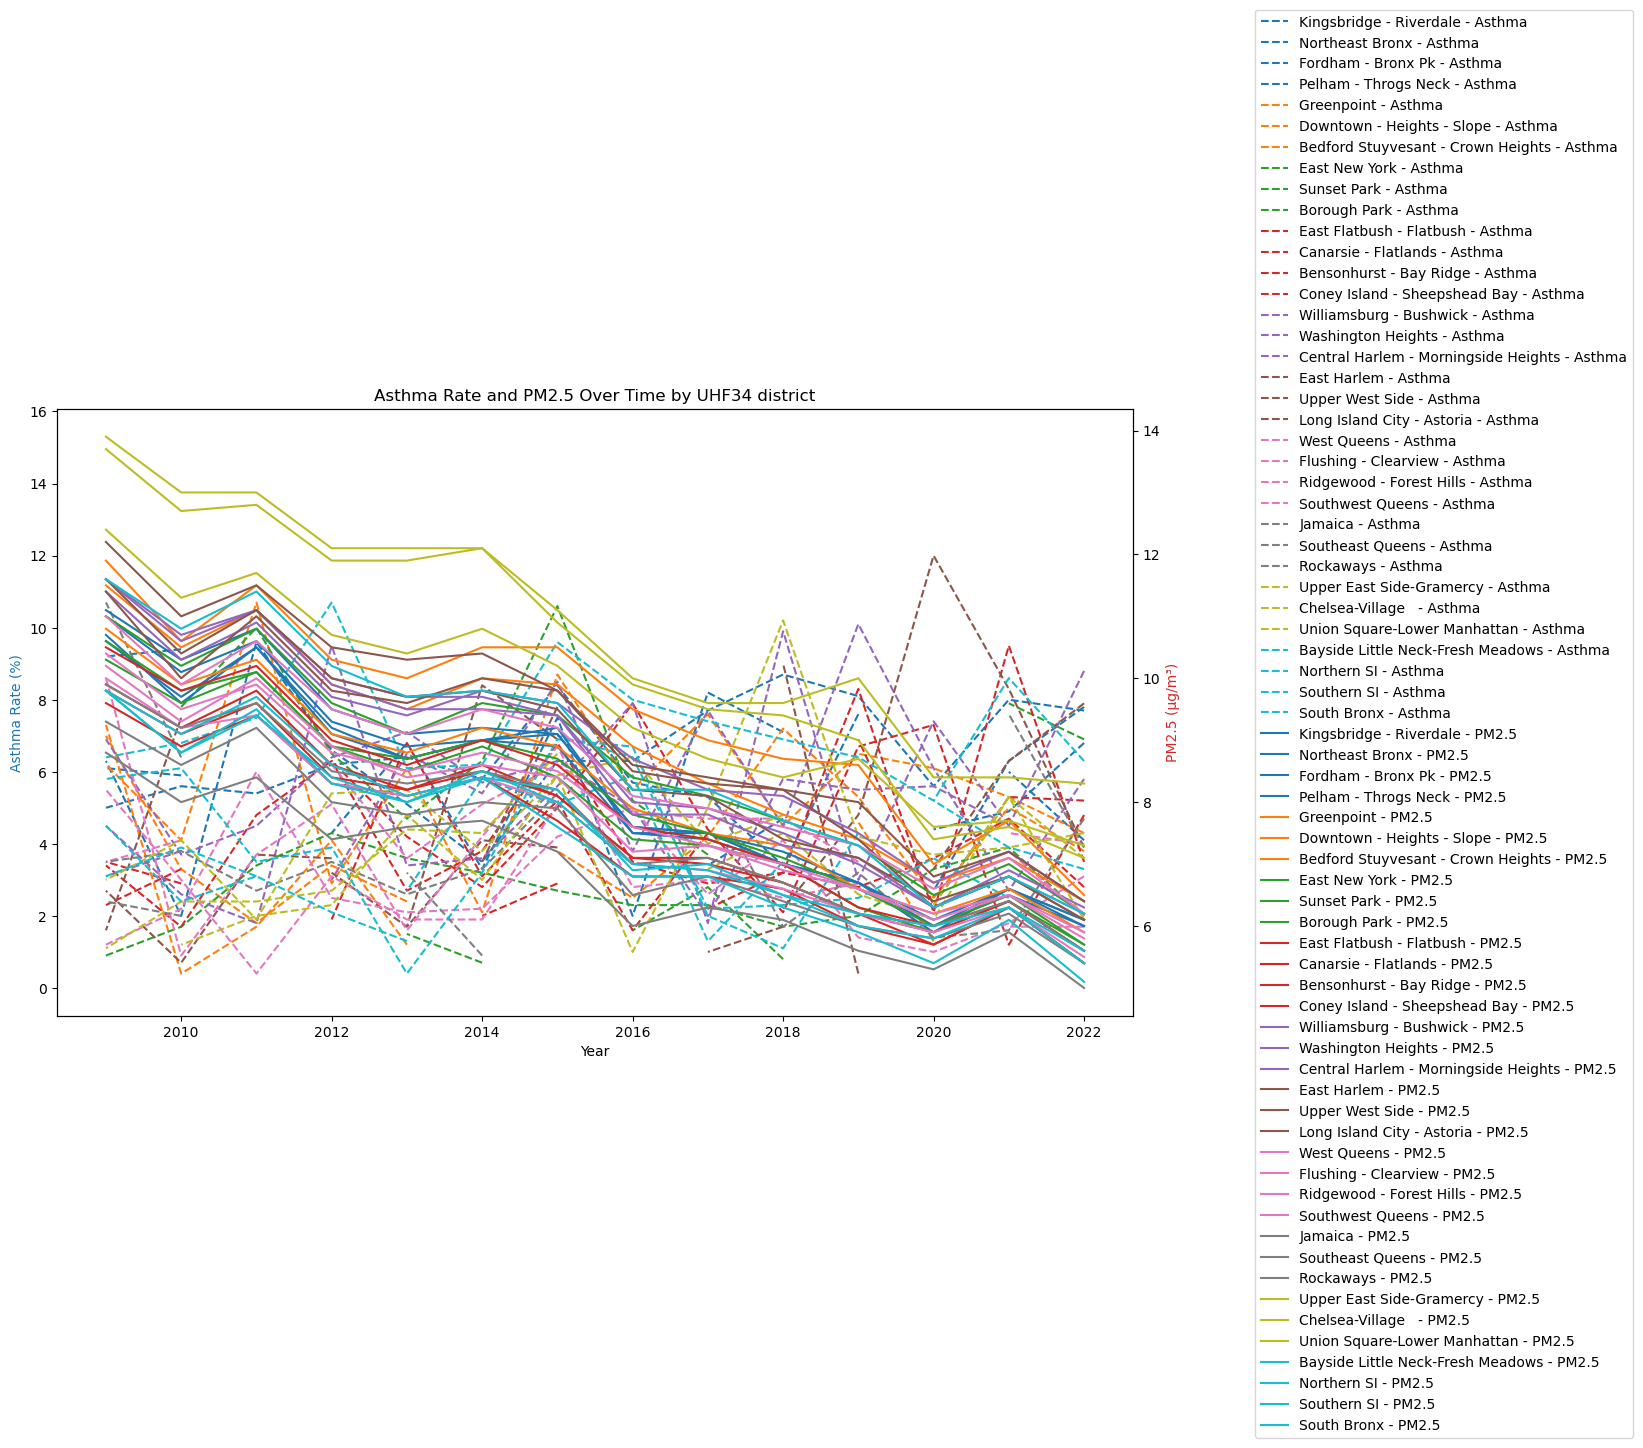

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assumendo che tu abbia già df_merged con: TimePeriod, Borough, AsthmaPercent, PM25
boroughs = df_merged["UHF34"].unique()
colors = plt.cm.get_cmap("tab10", len(boroughs))

fig, ax1 = plt.subplots(figsize=(12, 7))

# Colori coerenti per borough
for i, borough in enumerate(boroughs):
    bdata = df_merged[df_merged["UHF34"] == borough]
    ax1.plot(bdata["TimePeriod"], bdata["AsthmaPercent"],
             linestyle="--", color=colors(i), label=f"{borough} - Asthma")

# Secondo asse per PM2.5
ax2 = ax1.twinx()
for i, borough in enumerate(boroughs):
    bdata = df_merged[df_merged["UHF34"] == borough]
    ax2.plot(bdata["TimePeriod"], bdata["PM25"],
             linestyle="-", color=colors(i), label=f"{borough} - PM2.5")

# Etichette assi
ax1.set_xlabel("Year")
ax1.set_ylabel("Asthma Rate (%)", color="tab:blue")
ax2.set_ylabel("PM2.5 (µg/m³)", color="tab:red")
plt.title("Asthma Rate and PM2.5 Over Time by UHF34 district")

# Legenda combinata
# Legenda combinata (corretto)
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()

lines = lines1 + lines2
labels = labels1 + labels2

fig.legend(lines, labels,
           loc="center left",           # Start at center left
           bbox_to_anchor=(1.05, 0.5),   # Push it outside to the right
           borderaxespad=0.)


plt.tight_layout()
plt.show()


In [ ]:
# === 2. Download and load UHF34 GeoJSON ===
uhf34_geojson_url = "https://raw.githubusercontent.com/nycehs/NYC_geography/master/UHF34.geo.json"
uhf34_geojson_file = "uhf34.geojson"

if not os.path.exists(uhf34_geojson_file):
    response = requests.get(uhf34_geojson_url)
    response.raise_for_status()
    with open(uhf34_geojson_file, "w", encoding="utf-8") as f:
        f.write(response.text)
    print(f"Downloaded: {uhf34_geojson_file}")
else:
    print(f"Already exists: {uhf34_geojson_file}")

uhf34 = gpd.read_file(uhf34_geojson_file)
uhf34 = uhf34.rename(columns={"GEONAME": "UHF34"})

# === 3. Prepare GeoJSON per year ===
anni = sorted(df_merged["TimePeriod"].dropna().unique())
asma_jsons = {}
pm_jsons = {}

for year in anni:
    df_year = df_merged[df_merged["TimePeriod"] == year]
    merged = uhf34.merge(df_year, on="UHF34", how="left")
    asma_jsons[str(year)] = merged[["geometry", "UHF34", "AsthmaPercent"]].to_json()
    pm_jsons[str(year)] = merged[["geometry", "UHF34", "PM25"]].to_json()

# === 4. Set up sources ===
initial_year = str(anni[0])
asma_source = GeoJSONDataSource(geojson=asma_jsons[initial_year])
pm_source = GeoJSONDataSource(geojson=pm_jsons[initial_year])

# === 5. Color mappers ===
asma_mapper = LinearColorMapper(palette=Viridis256,
                                low=df_merged["AsthmaPercent"].min(),
                                high=df_merged["AsthmaPercent"].max())

pm_mapper = LinearColorMapper(palette=Viridis256,
                              low=df_merged["PM25"].min(),
                              high=df_merged["PM25"].max())

# === 6. Create Bokeh figure ===
p = figure(title=f"Asthma Rate per UHF34 - {initial_year}",
           tools="pan,wheel_zoom,reset",
           x_axis_location=None, y_axis_location=None)
p.grid.grid_line_color = None

# === 7. Create patches ===
asma_patch = p.patches("xs", "ys", source=asma_source,
                       fill_color={"field": "AsthmaPercent", "transform": asma_mapper},
                       line_color="white", line_width=0.5, fill_alpha=0.7,
                       visible=True)

pm_patch = p.patches("xs", "ys", source=pm_source,
                     fill_color={"field": "PM25", "transform": pm_mapper},
                     line_color="white", line_width=0.5, fill_alpha=0.7,
                     visible=False)

# === 8. Dynamic Hover Tool ===
hover_tool = HoverTool(
    tooltips=[
        ("UHF34", "@UHF34"),
        ("Asthma %", "@AsthmaPercent{0.0}%")
    ],
    renderers=[asma_patch]
)
p.add_tools(hover_tool)

# === 9. Color bar ===
color_bar = ColorBar(color_mapper=asma_mapper, label_standoff=12, location=(0, 0))
p.add_layout(color_bar, "right")

# === 10. Controls ===
dropdown = Select(title="Select Year", value=initial_year, options=[str(y) for y in anni])
metric_switch = RadioButtonGroup(labels=["Asthma (%)", "PM2.5 (\u00b5g/m\u00b3)"], active=0)

# === 11. Callback JS ===
callback = CustomJS(args=dict(
    dropdown=dropdown,
    metric_switch=metric_switch,
    asma_source=asma_source,
    pm_source=pm_source,
    asma_jsons=asma_jsons,
    pm_jsons=pm_jsons,
    asma_patch=asma_patch,
    pm_patch=pm_patch,
    color_bar=color_bar,
    asma_mapper=asma_mapper,
    pm_mapper=pm_mapper,
    plot=p,
    hover_tool=hover_tool
), code="""
    const year = dropdown.value;
    const metric = metric_switch.active === 0 ? "asma" : "pm";

    if (metric === "asma") {
        asma_source.geojson = asma_jsons[year];
        asma_patch.visible = true;
        pm_patch.visible = false;
        hover_tool.tooltips = [["UHF34", "@UHF34"], ["Asthma %", "@AsthmaPercent"]];
        hover_tool.renderers = [asma_patch];
        color_bar.color_mapper = asma_mapper;
        plot.title.text = `Asthma Rate per UHF34 - ${year}`;
    } else {
        pm_source.geojson = pm_jsons[year];
        asma_patch.visible = false;
        pm_patch.visible = true;
        hover_tool.tooltips = [["UHF34", "@UHF34"], ["PM2.5 (\u00b5g/m\u00b3)", "@PM25"]];
        hover_tool.renderers = [pm_patch];
        color_bar.color_mapper = pm_mapper;
        plot.title.text = `PM2.5 Levels per UHF34 - ${year}`;
    }
""")

dropdown.js_on_change("value", callback)
metric_switch.js_on_change("active", callback)

# === 12. Layout and save to HTML ===
layout = column(row(dropdown, metric_switch), p)
output_file("pm25_map_interactive.html")
save(layout)
print("Map saved as pm25_map_interactive.html")


Already exists: uhf34.geojson
Map saved as pm25_map_interactive.html
